# Mobïus vs. Capacities for fitness functions comparison
In this notebook, we will compare the performance of Mobïus and Capacities for fitness functions. We will test on both dynamic positive gaussian data and `iris` dataset.

In [47]:
# Import basic libraries
from palmerpenguins import load_penguins
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import time
from sklearn.preprocessing import LabelEncoder
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # for 3D projection
import os
import time
plt.style.use('_mpl-gallery')
os.chdir("/Users/hoangthuyduongvu/Desktop/FuzzSIM")


In [2]:
# Import personalized libraries
from fuzz.src.capacity import *
from fuzz.choquet.choquet import *
from fuzz.src.norm import *
from fuzz.src.knn import KNNFuzz
from fuzz.src.sim import S1, S2, S3
from fuzz.optim import *
from fuzz.utils import *
from fuzz.eval import leave_one_out
from fuzz.dataloader import *
from fuzz.choquet.d_choquet import *

#### Define results directory

In [66]:
# Use timestamps for saving results
timestamp = time.strftime("%Y%m%d-%H%M%S")

# Create a directory for results if it doesn't exist
results_dir = "results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

if not os.path.exists(os.path.join(results_dir, timestamp)):
    os.makedirs(os.path.join(results_dir, timestamp))

## Dynamic Positive Gaussian Data

In [67]:
data, labels = dynamic_generate_positive_gaussian_data(
    dim=3,
    nb_classes=3,
    nb_points_per_class=50,
    seed=42
)
data = batch_norm(data)
data[:5]

array([[0.        , 1.        , 0.01959192],
       [1.        , 0.        , 0.4070175 ],
       [0.        , 0.38090406, 1.        ],
       [0.6965442 , 0.        , 1.        ],
       [0.        , 1.        , 0.99405304]])

In [68]:
# Generate all possible mobius for training
features = list(range(len(data[0])))    # encode features as integers

nb_total = 5

# Input Mobius (10 mobius currently)
lst_mobius = []
for i in range(nb_total):
    mobius = generate_mobius(features, 2)
    mobius.pop(0)
    lst_mobius.append(mobius)

# Mutate all mobius
mutated = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    mutated_mobius = mutate(mobius, mutation_rate=0.8)
    mutated.append(mutated_mobius)

# Add mutated mobius to the list
lst_mobius.extend(mutated)

# Cross over all mobius
crossed_over = []
for i in range(len(lst_mobius)):
    for j in range(i + 1, len(lst_mobius) // 2):
        crossed = crossover(lst_mobius[np.random.randint(len(lst_mobius))], lst_mobius[np.random.randint(len(lst_mobius))])
        crossed_over.append(crossed)

# Add crossed over mobius to the list
lst_mobius.extend(crossed_over)
print(f"Total number of Möbius measures: {len(lst_mobius)}")

# Convert all Möbius measures to capacities
capacities_list = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    capacity = mobius_to_capacity(mobius, features)
    capacities_list.append(capacity)    
print('Test Möbius measures completed!')
print(f"Total number of capacities: {len(capacities_list)}")

Total number of Möbius measures: 20
Test Möbius measures completed!
Total number of capacities: 20


### Test on Mobïus


In [71]:
# Define hyperparameters
p = np.arange(0.25, 3, 0.25)  # p values for Choquet integral
q = np.arange(0.25, 3, 0.25)  # q values for Choquet integral
sim = S2  # similarity measures
choquet_version = 'linear'
verbose = False 
eval_type = 'crossval'  # evaluation type
sim_agent = 'mobius'  # similarity agent for d_Choquet

# Define training loop
best_indexes = []
best_accuracies = []
best_mobius = []
lst_p = []
lst_q = []
print("Starting training loop...")
start_time = time.time()
i = 0
for p_val in p:
    for q_val in q:
        i += 1
        if i % 10 == 0:
            print(f"Progress: {i}/{len(p) * len(q)}")
        FF_res = fitness_function(
            capacities_list=lst_mobius,
            DS=(data, labels),
            sim=sim,
            choquet_version=choquet_version,
            p=p_val,
            q=q_val,
            time_counter=False,
            verbose=verbose,
            eval_type=eval_type,
            sim_agent=sim_agent
        )
        best_indexes.append(np.argmin(FF_res))
        best_accuracies.append(-FF_res[np.argmin(FF_res)])
        best_mobius.append(lst_mobius[np.argmin(FF_res)])
        lst_p.append(p_val)
        lst_q.append(q_val)

end_time = time.time()
print(f"Training loop completed in {end_time - start_time:.2f} seconds.")

Starting training loop...
Progress: 10/121
Progress: 20/121
Progress: 30/121
Progress: 40/121
Progress: 50/121
Progress: 60/121
Progress: 70/121
Progress: 80/121
Progress: 90/121
Progress: 100/121
Progress: 110/121
Progress: 120/121
Training loop completed in 856.22 seconds.


Best index: 24, Best accuracy: 0.5
Best p: 0.75, Best q: 0.75
Best Möbius measure: ['[0]: 0.976', '[1]: 0.608', '[2]: 0.752', '[0, 1]: 0.754', '[0, 2]: 0.040', '[1, 2]: 0.010']

Best Capacity:
Capacity of [] is 0.000
Capacity of [0] is 0.311
Capacity of [1] is 0.194
Capacity of [2] is 0.239
Capacity of [0, 1] is 0.745
Capacity of [0, 2] is 0.563
Capacity of [1, 2] is 0.436
Capacity of [0, 1, 2] is 1.000
Result in 0.8205 seconds.
Best accuracy: 0.3333


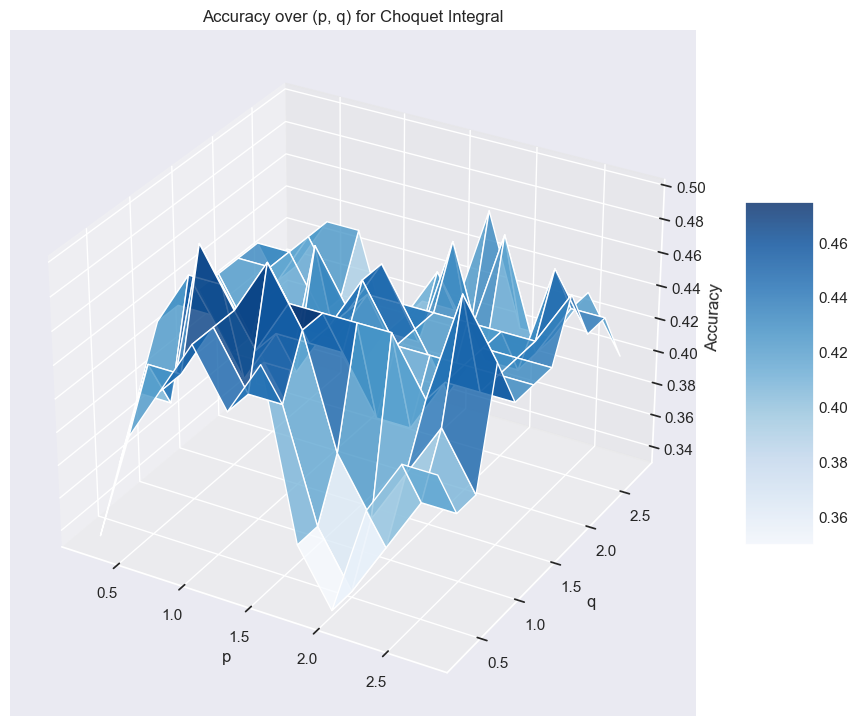

In [72]:
# Find the best index and accuracy
best_index = np.argmax(best_accuracies)
best_accuracy = best_accuracies[best_index]
print(f"Best index: {best_index}, Best accuracy: {best_accuracy}")

best_p = lst_p[best_index]
best_q = lst_q[best_index]
print(f"Best p: {best_p}, Best q: {best_q}")

# get best mobius
mobius = best_mobius[best_index]
print(f"Best Möbius measure: {[f'{m.X}: {m.mu:.3f}' for m in mobius]}")

# Convert mobius to capacity
best_capacity = mobius_to_capacity(mobius, features)
print("\nBest Capacity:")
for c in best_capacity:
    print(f"Capacity of {c.X} is {c.mu:.3f}")

# Evaluate the best capacity
best_accuracy = FuzzLOO(
    DS=(data, labels),
    mu=best_capacity,
    sim=S1,
    choquet_version='d_choquet',
    p=1,
    q=1,
    time_counter=True
)
print(f"Best accuracy: {best_accuracy:.4f}")

# 3D plotting
P, Q = np.meshgrid(p, q, indexing='ij')  # Create meshgrid with shape (len(p), len(q))

# Reshape best_accuracies to the same shape
accuracy_grid = np.array(best_accuracies).reshape(len(p), len(q))

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(P, Q, accuracy_grid, cmap=cm.Blues, edgecolor='w', alpha=0.8)

# Labels and title
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_zlabel('Accuracy')
ax.set_title('Accuracy over (p, q) for Choquet Integral')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)  # Add color bar
plt.show()

#### Saving results

In [76]:
tmp_x = np.arange(len(data))
tmp_y = np.arange(len(data))

np.random.shuffle(tmp_x)
np.random.shuffle(tmp_y)

idx_x = tmp_x
idx_y = tmp_y

results = []
lst_mobius = []  # Use the best mobius measure
lst_capacity = []  # Use the best capacity

for i in range(len(data)):
    choquet_mobius = Choquet(X=data[i], mu=mobius, version='linear', p=best_p, q=best_q)
    choquet_capa = Choquet(X=data[i], mu=best_capacity, version='d_choquet', p=best_p, q=best_q)

    results.append({
        'index': i,
        'mobius_value': choquet_mobius.choquet,
        'capacity_value': choquet_capa.choquet,
        'label': labels[i]
    })
    lst_mobius.append(choquet_mobius.choquet)
    lst_capacity.append(choquet_capa.choquet)

# Save results to a txt file
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(results_dir, timestamp, 'choquet_mobius_results_dynamic_pos_gaussian.txt'), index=False)

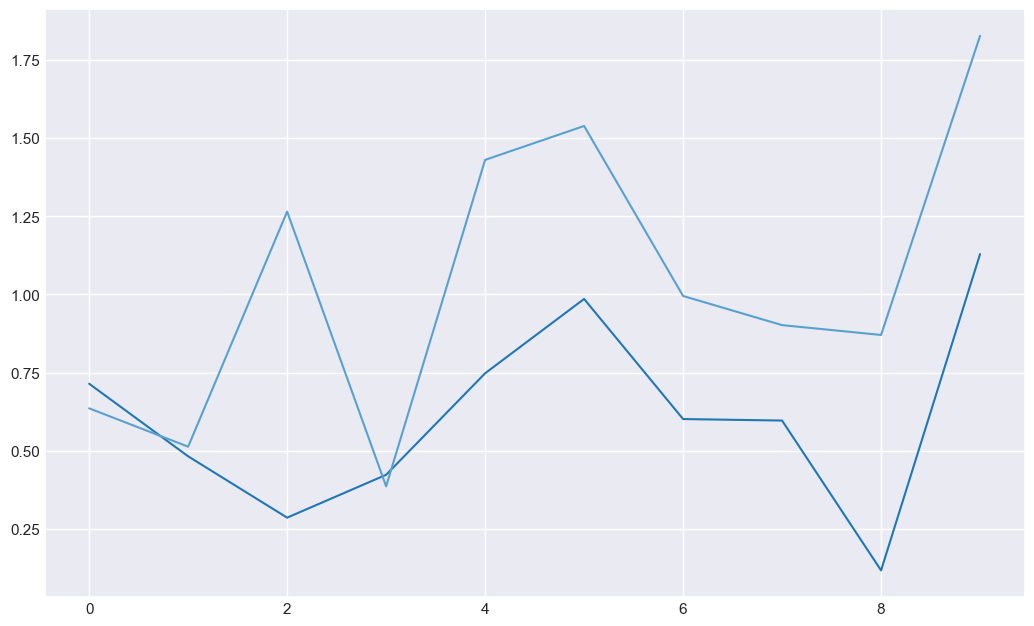

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(lst_mobius[:10], label='Choquet Mobius', markersize=5)
plt.plot(lst_capacity[:10], label='Choquet Capacity', markersize=5)

### Test on Capacities

In [ ]:
# Define hyperparameters
p = np.arange(0.25, 3, 0.25)  # p values for Choquet integral
q = np.arange(0.25, 3, 0.25)  # q values for Choquet integral
sim = S2  # similarity measures
choquet_version = 'd_choquet'
verbose = False 
eval_type = 'crossval'  # evaluation type
sim_agent = 'capacity'  # similarity agent for d_Choquet

# Define training loop
best_indexes = []
best_accuracies = []
best_mobius = []
lst_p = []
lst_q = []

print("Starting training loop...")
start_time = time.time()
i = 0
for p_val in p:
    for q_val in q:
        i += 1
        if i % 10 == 0:
            print(f"Progress: {i}/{len(p) * len(q)}")
        FF_res = fitness_function(
            capacities_list=capacities_list,
            DS=(data, labels),
            sim=sim,
            choquet_version=choquet_version,
            p=p_val,
            q=q_val,
            time_counter=False,
            verbose=verbose,
            eval_type=eval_type,
            sim_agent=sim_agent,
        )
        best_indexes.append(np.argmin(FF_res))
        best_accuracies.append(-FF_res[np.argmin(FF_res)])
        best_mobius.append(lst_mobius[np.argmin(FF_res)])
        lst_p.append(p_val)
        lst_q.append(q_val)

end_time = time.time()
print(f"Training loop completed in {end_time - start_time:.2f} seconds.")

Starting training loop...
Progress: 10/121
Progress: 20/121
Progress: 30/121
Progress: 40/121
Progress: 50/121
Progress: 60/121
Progress: 70/121
Progress: 80/121
Progress: 90/121
Progress: 100/121
Progress: 110/121
Progress: 120/121
Training loop completed in 476.30 seconds.


Best index: 1, Best accuracy: 0.5333333333333333
Best Möbius measure: ['[0]: 0.495', '[1]: 0.518', '[2]: 0.752', '[0, 1]: 0.399', '[0, 2]: 0.040', '[1, 2]: 0.284']


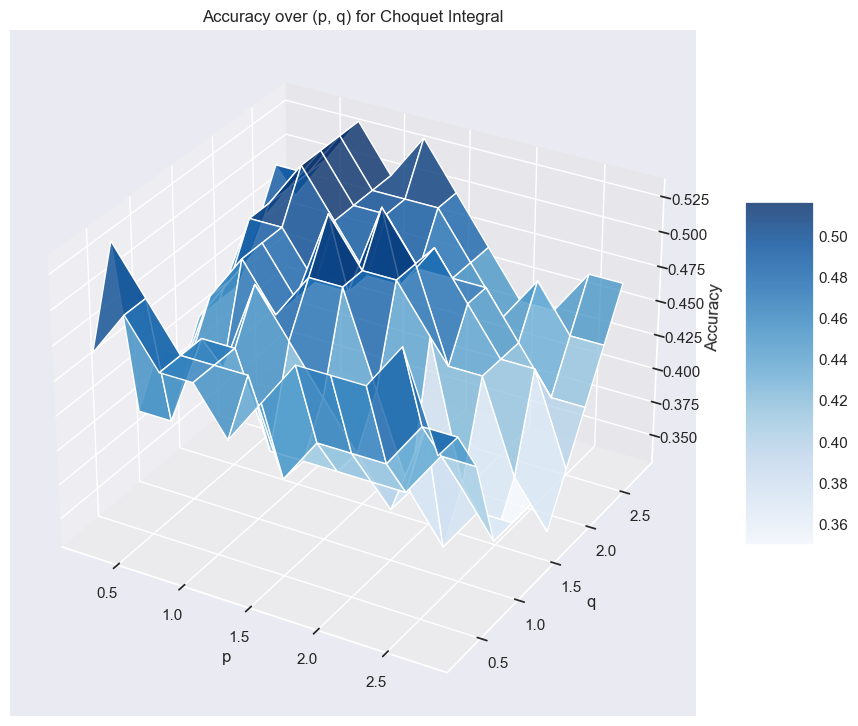

In [ ]:
# Find the best index and accuracy
best_index = np.argmax(best_accuracies)
best_accuracy = best_accuracies[best_index]
print(f"Best index: {best_index}, Best accuracy: {best_accuracy}")

best_p = lst_p[best_index]
best_q = lst_q[best_index]
print(f"Best p: {best_p}, Best q: {best_q}")

# get best mobius
mobius = best_mobius[best_index]
print(f"Best Möbius measure: {[f'{m.X}: {m.mu:.3f}' for m in mobius]}")

# 3D plotting
P, Q = np.meshgrid(p, q, indexing='ij')  # Create meshgrid with shape (len(p), len(q))

# Reshape best_accuracies to the same shape
accuracy_grid = np.array(best_accuracies).reshape(len(p), len(q))

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(P, Q, accuracy_grid, cmap=cm.Blues, edgecolor='w', alpha=0.8)

# Labels and title
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_zlabel('Accuracy')
ax.set_title('Accuracy over (p, q) for Choquet Integral')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)  # Add color bar
plt.show()

## `Iris` Dataset

In [63]:
# Load data 
iris_data = load_iris()
iris = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
iris['target'] = iris_data.target
data, labels = iris.iloc[:, :-1].values, iris.iloc[:, -1].values
data = batch_norm(np.array(data, dtype=np.float32))
data[:5]

array([[1.        , 0.67346936, 0.24489795, 0.        ],
       [1.        , 0.59574461, 0.25531912, 0.        ],
       [1.        , 0.66666669, 0.24444443, 0.        ],
       [1.        , 0.65909088, 0.29545453, 0.        ],
       [1.        , 0.70833325, 0.24999997, 0.        ]])

In [64]:
# Generate all possible mobius for training
features = list(range(len(data[0])))    # encode features as integers

nb_total = 5

# Input Mobius (10 mobius currently)
lst_mobius = []
for i in range(nb_total):
    mobius = generate_mobius(features, 2)
    mobius.pop(0)
    lst_mobius.append(mobius)

# Mutate all mobius
mutated = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    mutated_mobius = mutate(mobius, mutation_rate=0.8)
    mutated.append(mutated_mobius)

# Add mutated mobius to the list
lst_mobius.extend(mutated)

# Cross over all mobius
crossed_over = []
for i in range(len(lst_mobius)):
    for j in range(i + 1, len(lst_mobius) // 2):
        crossed = crossover(lst_mobius[np.random.randint(len(lst_mobius))], lst_mobius[np.random.randint(len(lst_mobius))])
        crossed_over.append(crossed)

# Add crossed over mobius to the list
lst_mobius.extend(crossed_over)
print(f"Total number of Möbius measures: {len(lst_mobius)}")

# Convert all Möbius measures to capacities
capacities_list = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    capacity = mobius_to_capacity(mobius, features)
    capacities_list.append(capacity)    
print('Test Möbius measures completed!')
print(f"Total number of capacities: {len(capacities_list)}")

Total number of Möbius measures: 20
Test Möbius measures completed!
Total number of capacities: 20


### Test on Mobïus

In [ ]:
# Define hyperparameters
p = np.arange(0.25, 3, 0.25)  # p values for Choquet integral
q = np.arange(0.25, 3, 0.25)  # q values for Choquet integral
sim = S2  # similarity measures
choquet_version = 'linear'
verbose = False 
eval_type = 'crossval'  # evaluation type
sim_agent = 'mobius'  # similarity agent for d_Choquet

# Define training loop
best_indexes = []
best_accuracies = []
best_mobius = []
lst_p = []
lst_q = []
print("Starting training loop...")
start_time = time.time()
i = 0
for p_val in p:
    for q_val in q:
        i += 1
        if i % 10 == 0:
            print(f"Progress: {i}/{len(p) * len(q)}")
        FF_res = fitness_function(
            capacities_list=lst_mobius,
            DS=(data, labels),
            sim=sim,
            choquet_version=choquet_version,
            p=p_val,
            q=q_val,
            time_counter=False,
            verbose=verbose,
            eval_type=eval_type,
            sim_agent=sim_agent
        )
        best_indexes.append(np.argmin(FF_res))
        best_accuracies.append(-FF_res[np.argmin(FF_res)])
        best_mobius.append(lst_mobius[np.argmin(FF_res)])
        lst_p.append(p_val)
        lst_q.append(q_val)

end_time = time.time()
print(f"Training loop completed in {end_time - start_time:.2f} seconds.")

Starting training loop...
Progress: 10/121


KeyboardInterrupt: 

Best index: 3, Best accuracy: 0.8333333333333334
Best Möbius measure: ['[0]: 0.790', '[1]: 0.606', '[2]: 0.926', '[3]: 0.651', '[0, 1]: 0.915', '[0, 2]: 0.850', '[0, 3]: 0.449', '[1, 2]: 0.095', '[1, 3]: 0.371', '[2, 3]: 0.669']

Best Capacity:
Capacity of [] is 0.000
Capacity of [0] is 0.125
Capacity of [1] is 0.096
Capacity of [2] is 0.146
Capacity of [3] is 0.103
Capacity of [0, 1] is 0.366
Capacity of [0, 2] is 0.406
Capacity of [0, 3] is 0.299
Capacity of [1, 2] is 0.257
Capacity of [1, 3] is 0.257
Capacity of [2, 3] is 0.355
Capacity of [0, 1, 2] is 0.662
Capacity of [0, 1, 3] is 0.598
Capacity of [0, 2, 3] is 0.686
Capacity of [1, 2, 3] is 0.525
Capacity of [0, 1, 2, 3] is 1.000
Result in 1.5516 seconds.
Best accuracy: 0.6667


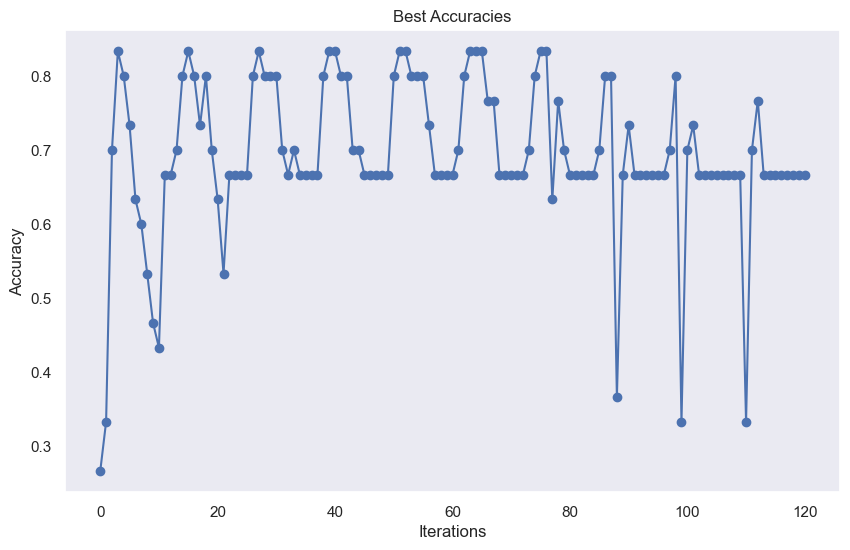

In [ ]:
# Find the best index and accuracy
best_index = np.argmax(best_accuracies)
best_accuracy = best_accuracies[best_index]
print(f"Best index: {best_index}, Best accuracy: {best_accuracy}")

best_p = lst_p[best_index]
best_q = lst_q[best_index]
print(f"Best p: {best_p}, Best q: {best_q}")

# get best mobius
mobius = best_mobius[best_index]
print(f"Best Möbius measure: {[f'{m.X}: {m.mu:.3f}' for m in mobius]}")

# Convert mobius to capacity
best_capacity = mobius_to_capacity(mobius, features)
print("\nBest Capacity:")
for c in best_capacity:
    print(f"Capacity of {c.X} is {c.mu:.3f}")

# Evaluate the best capacity
best_accuracy = FuzzLOO(
    DS=(data, labels),
    mu=best_capacity,
    sim=S1,
    choquet_version='d_choquet',
    p=1,
    q=1,
    time_counter=True
)
print(f"Best accuracy: {best_accuracy:.4f}")


# 3D plotting
P, Q = np.meshgrid(p, q, indexing='ij')  # Create meshgrid with shape (len(p), len(q))

# Reshape best_accuracies to the same shape
accuracy_grid = np.array(best_accuracies).reshape(len(p), len(q))

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(P, Q, accuracy_grid, cmap=cm.Blues, edgecolor='w', alpha=0.8)

# Labels and title
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_zlabel('Accuracy')
ax.set_title('Accuracy over (p, q) for Choquet Integral')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)  # Add color bar
plt.show()

In [ ]:
tmp_x = np.arange(len(data))
tmp_y = np.arange(len(data))

np.random.shuffle(tmp_x)
np.random.shuffle(tmp_y)

idx_x = tmp_x
idx_y = tmp_y

results = []

for i in range(len(data)):
    choquet_mobius = Choquet(X=data[i], mu=mobius, version='linear', p=best_p, q=best_q)
    choquet_capa = Choquet(X=data[i], mu=best_capacity, version='d_choquet', p=best_p, q=best_q)

    results.append({
        'index': i,
        'mobius_value': choquet_mobius,
        'capacity_value': choquet_capa,
        'label': labels[i]
    })

# Save results to a txt file
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(results_dir, timestamp, 'choquet_mobius_results_iris.txt'), index=False)

### Test on Capacities

In [ ]:
# Define hyperparameters
p = np.arange(0.25, 3, 0.25)  # p values for Choquet integral
q = np.arange(0.25, 3, 0.25)  # q values for Choquet integral
sim = S2  # similarity measures
choquet_version = 'd_choquet'
verbose = False 
eval_type = 'crossval'  # evaluation type
sim_agent = 'capacity'  # similarity agent for d_Choquet

# Define training loop
best_indexes = []
best_accuracies = []
best_mobius = []
lst_p = []
lst_q = []
print("Starting training loop...")
start_time = time.time()
i = 0
for p_val in p:
    for q_val in q:
        i += 1
        if i % 10 == 0:
            print(f"Progress: {i}/{len(p) * len(q)}")
        FF_res = fitness_function(
            capacities_list=lst_mobius,
            DS=(data, labels),
            sim=sim,
            choquet_version=choquet_version,
            p=p_val,
            q=q_val,
            time_counter=False,
            verbose=verbose,
            eval_type=eval_type,
            sim_agent=sim_agent
        )
        best_indexes.append(np.argmin(FF_res))
        best_accuracies.append(-FF_res[np.argmin(FF_res)])
        best_mobius.append(lst_mobius[np.argmin(FF_res)])

end_time = time.time()
print(f"Training loop completed in {end_time - start_time:.2f} seconds.")

Starting training loop...
Progress: 10/121
Progress: 20/121
Progress: 30/121
Progress: 40/121
Progress: 50/121
Progress: 60/121
Progress: 70/121
Progress: 80/121
Progress: 90/121
Progress: 100/121
Progress: 110/121
Progress: 120/121
Training loop completed in 421.28 seconds.


Best index: 1, Best accuracy: 0.6666666666666666
Best Möbius measure: ['[0]: 0.790', '[1]: 0.606', '[2]: 0.926', '[3]: 0.651', '[0, 1]: 0.915', '[0, 2]: 0.850', '[0, 3]: 0.449', '[1, 2]: 0.095', '[1, 3]: 0.371', '[2, 3]: 0.669']


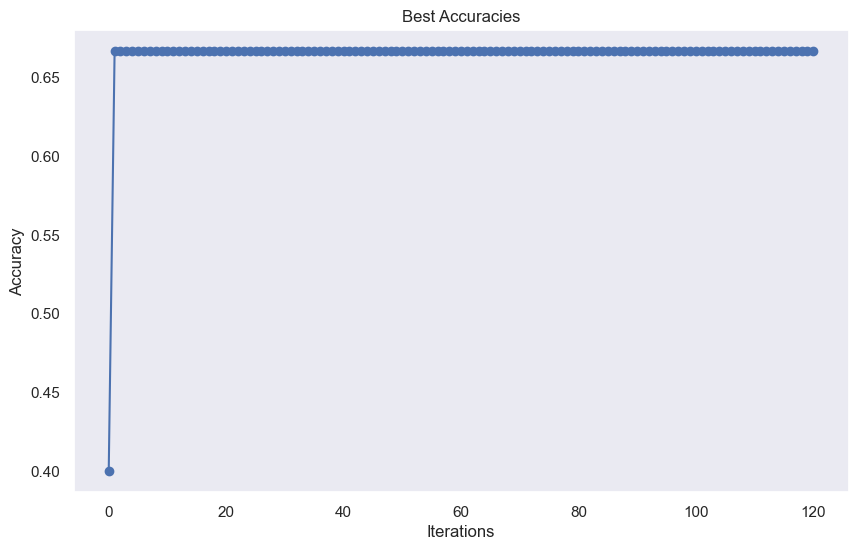

In [ ]:
# Find the best index and accuracy
best_index = np.argmax(best_accuracies)
best_accuracy = best_accuracies[best_index]
print(f"Best index: {best_index}, Best accuracy: {best_accuracy}")

best_p = lst_p[best_index]
best_q = lst_q[best_index]
print(f"Best p: {best_p}, Best q: {best_q}")

# get best mobius
mobius = best_mobius[best_index]
print(f"Best Möbius measure: {[f'{m.X}: {m.mu:.3f}' for m in mobius]}")

# 3D plotting
P, Q = np.meshgrid(p, q, indexing='ij')  # Create meshgrid with shape (len(p), len(q))

# Reshape best_accuracies to the same shape
accuracy_grid = np.array(best_accuracies).reshape(len(p), len(q))

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(P, Q, accuracy_grid, cmap=cm.Blues, edgecolor='w', alpha=0.8)

# Labels and title
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_zlabel('Accuracy')
ax.set_title('Accuracy over (p, q) for Choquet Integral')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)  # Add color bar
plt.show()

---
## Conclusion

| Dataset                | Method    | Best idx (among 20) | Best accuracy | Time (s) |
|-----------------------|-----------|--------------|-----------------|----------|
| Dynamic Positive Gaussian | Mobïus   | 24         | 0.5 - 0.3267 (associated capacity)           | 549.23 - 121 loops     |
| Dynamic Positive Gaussian | Capacities | 99         | 0.56           | 426.72 - 121 loops     |
| Iris Dataset          | Mobïus    | 3        | 0.84 - 0.67 (associated capacity)           | 1162.32 - 121 loops      |
| Iris Dataset          | Capacities | 1       | 0.66           | 421.28 - 121 loops    |